---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Norah Jones
    affiliations:
      - id: cmu
        name: Carnegie Mellon University
        city: Pittsburgh
        state: PA
      - id: chicago
        name: University of Chicago
        city: Chicago
        state: IL
  - name: John Hamm
    affiliations:
      - ref: cmu
      - name: University of California, San Diego
        city: San Diego
        state: CA
number-sections: true
date: "2024-11-21"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [22]:
#| eval: true
#| echo: true
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./data/lightcast_job_postings.csv")

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

df.printSchema() # comment this line when rendering the submission
df.show(5)

---This is Diagnostic check, No need to print it in the final doc---
root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATIO

# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [23]:
#| eval: false
#| echo: true
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

df = df.dropna(subset=["SALARY", "MODELED_DURATION", "MIN_EDULEVELS", "TITLE_NAME"
                       ])

categorical_cols = ["TITLE_NAME"]

label_col = "SALARY"

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_cols]

assembler = VectorAssembler(
    inputCols=["MODELED_DURATION", "MIN_EDULEVELS"] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)

pipeline = Pipeline(stages=indexers + encoders + [assembler])
data = pipeline.fit(df).transform(df).select("SALARY", "features")
data.show(5,False)

+------+-------------------------------+
|SALARY|features                       |
+------+-------------------------------+
|92500 |(2681,[0,1,4],[15.0,99.0,1.0]) |
|110155|(2681,[0,1,16],[10.0,2.0,1.0]) |
|107645|(2681,[0,2],[41.0,1.0])        |
|192800|(2681,[0,1,128],[55.0,2.0,1.0])|
|81286 |(2681,[0,1,4],[12.0,99.0,1.0]) |
+------+-------------------------------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [24]:
#| eval: true
#| echo: false
train_data, test_data = data.randomSplit([0.8, 0.2], seed=612)
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

(17545, 2)


(4362, 2)


# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [25]:
#| eval: false
#| echo: false
from pyspark.ml.regression import LinearRegression

feature_names = assembler.getInputCols()

lr = LinearRegression(featuresCol="features", labelCol="SALARY", regParam=0.1)

lr_model = lr.fit(train_data)
summary = lr_model.summary

# Coefficients and Intercept
# print("Intercept: {:.4f}".format(glr_model.intercept))
# print("Coefficients:")
# for i, coef in enumerate(glr_model.coefficients):
#     print(f"  Feature {i + 1}: {coef:.4f}")

# Summary stats
# print("\n--- Regression Summary ---")
# print("Coefficient Standard Errors:", [f"{val:.4f}" for val in summary.coefficientStandardErrors])
# print("T Values:", [f"{val:.4f}" for val in summary.tValues])
# print("P Values:", [f"{val:.4f}" for val in summary.pValues])

# print(f"\nDispersion: {summary.dispersion:.4f}")
# print(f"Null Deviance: {summary.nullDeviance:.4f}")
# print(f"Residual DF Null: {summary.residualDegreeOfFreedomNull}")
# print(f"Deviance: {summary.deviance:.4f}")
# print(f"Residual DF: {summary.residualDegreeOfFreedom}")
# print(f"AIC: {summary.aic:.4f}")

continuous_cols = ["MODELED_DURATION", "MIN_EDULEVELS"]
assembler_inputs = continuous_cols + [f"{col}_vec" for col in categorical_cols]

# We can assume OneHotEncoder expands each categorical col into N dummy vars
# So get actual vector size by checking the transformed vector's size
from pyspark.ml.linalg import DenseVector

# Get one example vector to see the number of expanded features
first_row = data.select("features").head()[0]
vector_size = len(first_row)

# Now create dummy feature names manually
expanded_feature_names = []

# Add continuous feature names directly
expanded_feature_names += continuous_cols

# Estimate expanded categorical feature names
for col in categorical_cols:
    onehot_size_guess = vector_size - len(continuous_cols)
    expanded_feature_names += [f"{col}_vec_{i}" for i in range(onehot_size_guess)]

# Then:
features = ["Intercept"] + expanded_feature_names




# 2. Construct full table including intercept

coefs = [lr_model.intercept] + list(lr_model.coefficients)
se = list(summary.coefficientStandardErrors)
tvals = list(summary.tValues)
pvals = list(summary.pValues)

print("---This is Diagnostic check, No need to print it in the final doc---")
print("Length of features:", len(features))
print("Length of coefs:", len(coefs))
print("Length of se:", len(se))
print("Length of tvals:", len(tvals))
print("Length of pvals:", len(pvals))

---This is Diagnostic check, No need to print it in the final doc---
Length of features: 2682
Length of coefs: 2682
Length of se: 2682
Length of tvals: 2682
Length of pvals: 2682


## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [26]:
#| eval: true
#| echo: false
import pandas as pd
from tabulate import tabulate
import pandas as pd


coef_table = pd.DataFrame({
    # "Feature": features,
    "Estimate": coefs,
    "Std Error": se,
    "t-stat": tvals,
    "P-Value": pvals
})

# 4. Optional pretty print
print(tabulate(coef_table, headers="keys", tablefmt="pretty"))

# 5. Save for report
# coef_table.to_csv("_output/glr_summary_pretty.csv", index=False)


+------+---------------------+--------------------+------------------------+------------------------+
|      |      Estimate       |     Std Error      |         t-stat         |        P-Value         |
+------+---------------------+--------------------+------------------------+------------------------+
|  0   |  51213.86589515266  | 20.06305862489943  |   0.9816384074308314   |  0.32629399714473095   |
|  1   | 19.694668916737683  | 6.701411814798656  |   4.989499345059322    |   6.122006661613e-07   |
|  2   |  33.4366898609107   | 28909.90719001252  |   1.3675099768822088   |  0.17148619020237277   |
|  3   |  39534.58651308082  | 28929.141860534313 |   1.7816864569417674   |  0.07482078873934905   |
|  4   |  51542.66026386115  | 28928.24454214934  |   1.891514922715411    |  0.058575064678484834  |
|  5   |  54718.20623943612  | 28941.882366841637 |   3.6973376628909453   | 0.00021865616535876597 |
|  6   | 107007.91170988292  | 28955.89714902925  |   3.160151561964475    | 0.001

# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


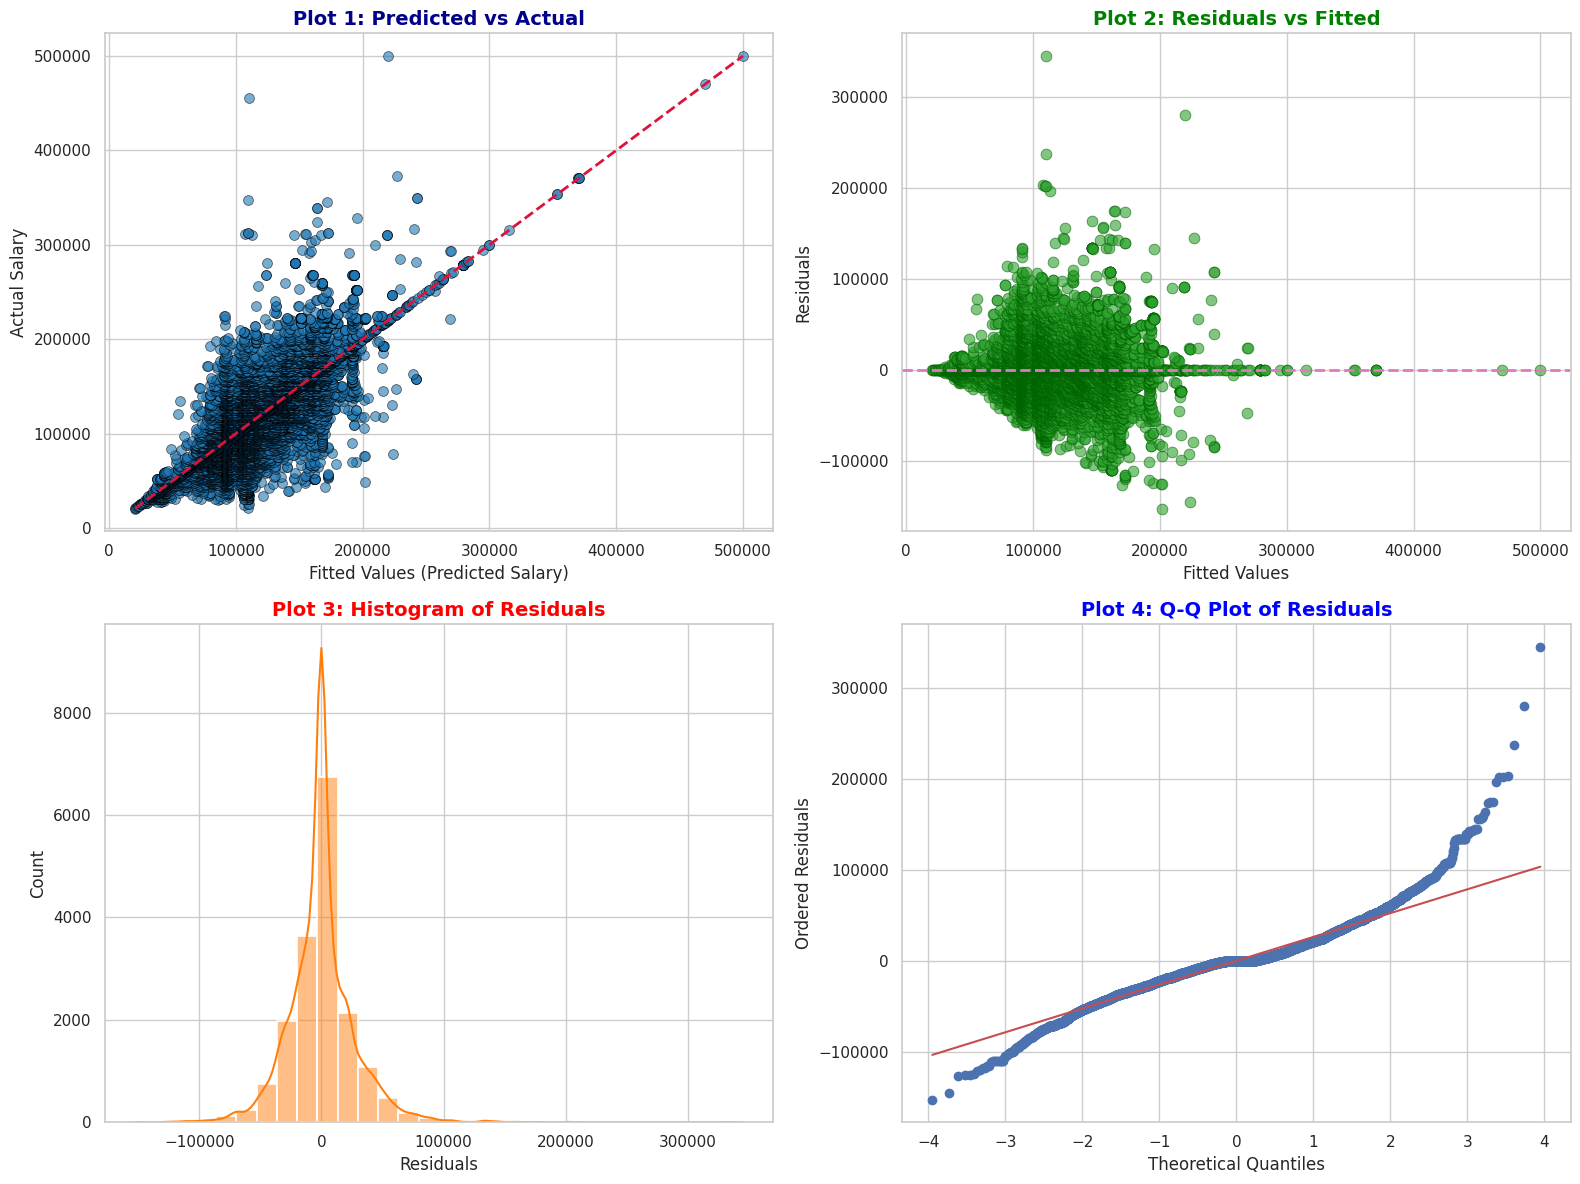

In [42]:
#| eval: true
#| echo: false
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Load predictions from GLR model
df_pred = summary.predictions.select("SALARY", "prediction")

# Compute residuals
df_pred = df_pred.withColumn("residuals", df_pred["SALARY"] - df_pred["prediction"])
df_pred = df_pred.withColumn("fitted", df_pred["prediction"])

# Standardized residuals
pandas_df = df_pred.toPandas()
res_mean = pandas_df["residuals"].mean()
res_std = pandas_df["residuals"].std()
pandas_df["std_residuals"] = (pandas_df["residuals"] - res_mean) / res_std

# Square root of standardized residuals (for Scale-Location)
pandas_df["sqrt_std_resid"] = np.sqrt(np.abs(pandas_df["std_residuals"]))


plt.figure(figsize=(16, 12))
sns.set_theme(style="whitegrid")

# ——— Plot 1: Predicted vs Actual ———
plt.subplot(2, 2, 1)
sns.scatterplot(x="fitted", y="SALARY", data=pandas_df, s=50, color="#1f77b4", edgecolor="black", alpha=0.6)
plt.plot([pandas_df["fitted"].min(), pandas_df["fitted"].max()],
         [pandas_df["fitted"].min(), pandas_df["fitted"].max()],
         linestyle="--", color="crimson", linewidth=2)
plt.xlabel("Fitted Values (Predicted Salary)", fontsize=12)
plt.ylabel("Actual Salary", fontsize=12)
plt.title("Plot 1: Predicted vs Actual", fontsize=14, fontweight="bold", color = "darkblue")

# ——— Plot 2: Residuals vs Fitted ———
plt.subplot(2, 2, 2)
sns.scatterplot(
    x="fitted", y="residuals", data=pandas_df,
    color="#2ca02c", edgecolor="darkgreen", s=60, alpha=0.6, marker="o"
)
plt.axhline(0, color="#e377c2", linestyle="--", linewidth=2)
plt.title("Plot 2: Residuals vs Fitted", fontsize=14, fontweight="bold", color="green")
plt.xlabel("Fitted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)

# ——— Plot 3: Histogram of Residuals ———
plt.subplot(2, 2, 3)
sns.histplot(
    pandas_df["residuals"], bins=30, kde=True,
    color="#ff7f0e", edgecolor="white", linewidth=1.2
)
plt.title("Plot 3: Histogram of Residuals", fontsize=14, fontweight="bold", color="red")
plt.xlabel("Residuals", fontsize=12)

# ——— Plot 4: Q-Q Plot ———
plt.subplot(2, 2, 4)
stats.probplot(pandas_df["residuals"], dist="norm", plot=plt)
plt.title("Plot 4: Q-Q Plot of Residuals", fontsize=14, fontweight="bold", color="blue")
plt.xlabel("Theoretical Quantiles", fontsize=12)
plt.ylabel("Ordered Residuals", fontsize=12)


plt.tight_layout()
plt.savefig("_output/glr_diagnostic_classic.png")
plt.show()

Plot 1: Predicted vs Actual
The predicted values align reasonably well with the actual salaries along the red y = x reference line, though some dispersion and underestimation appear for higher salary ranges. This indicates the model captures general salary trends but struggles with high-value outliers.

Plot 2: Residuals vs Fitted
Residuals are mostly centered around zero, but the fan-shaped spread reveals increasing variance for larger predicted salaries. This heteroscedasticity suggests the model’s error increases with salary, violating the constant variance assumption.

Plot 3: Histogram of Residuals
The histogram shows a peaked and slightly right-skewed distribution with a long tail, deviating from normality. This suggests residuals are not symmetrically distributed, which may affect confidence intervals and inference reliability.

Plot 4: Q-Q Plot of Residuals
The Q-Q plot shows significant deviation from the straight line at both tails, confirming non-normal residuals. This implies that the model errors are not normally distributed and highlights potential issues with model assumptions.

# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [28]:
#| eval: true
#| echo: false
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg, count
from pyspark.ml.regression import GeneralizedLinearRegression
import numpy as np
import math


glr = GeneralizedLinearRegression(featuresCol="features", labelCol="SALARY", family="gaussian", link="identity")
glr_model = glr.fit(train_data)

# Correct summary object
summary = glr_model.summary


pred_glr = glr_model.transform(test_data)

# R²
r2_eval = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
r2 = r2_eval.evaluate(pred_glr)
# AIC from GLR summary
aic = summary.aic

# BIC calculation
n = pred_glr.count() 
k = len(lr_model.coefficients) + 1 
rss = pred_glr.withColumn("squared_error", pow(col("SALARY") - col("prediction"), 2)) \
              .agg({"squared_error": "sum"}).first()[0]
bic = n * np.log(rss / n) + k * np.log(n)

# RMSE manually
residuals_df = pred_glr.withColumn("squared_error", pow(col("SALARY") - col("prediction"), 2))
rmse_val = residuals_df.agg(avg("squared_error")).first()[0]
rmse = math.sqrt(rmse_val)

25/04/10 20:39:24 WARN Instrumentation: [e78207eb] regParam is zero, which might cause numerical instability and overfitting.


25/04/10 20:39:33 WARN Instrumentation: [e78207eb] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

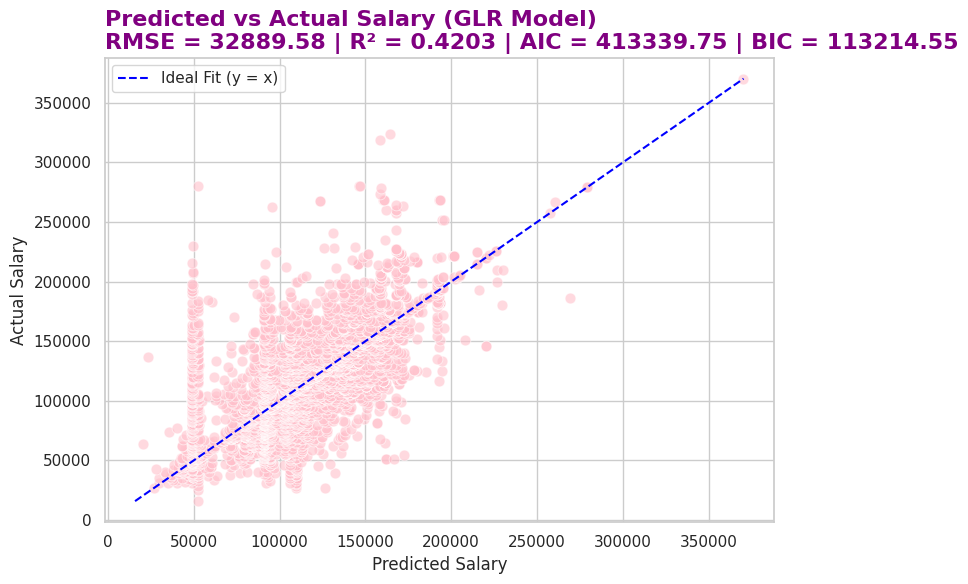

In [39]:
#| eval: true
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert GLR predictions to pandas
pandas_df = pred_glr.select("SALARY", "prediction").toPandas()

# Plot
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
# Scatter plot
sns.scatterplot(x="prediction", y="SALARY", data=pandas_df, s=60, color="pink", edgecolor="white", alpha=0.6)

# Ideal fit line (y = x)
min_val = min(pandas_df["SALARY"].min(), pandas_df["prediction"].min())
max_val = max(pandas_df["SALARY"].max(), pandas_df["prediction"].max())
plt.plot([min_val, max_val], [min_val, max_val], color="blue", linestyle="--", label="Ideal Fit (y = x)")

# Titles and labels
plt.title(
    f"Predicted vs Actual Salary (GLR Model)\n"
    f"RMSE = {rmse:.2f} | R² = {r2:.4f} | AIC = {aic:.2f} | BIC = {bic:.2f}",
    loc="left", fontsize=16, fontweight="bold", fontname="DejaVu Sans", color = "purple"
)
plt.xlabel("Predicted Salary")
plt.ylabel("Actual Salary")
plt.legend()
plt.tight_layout()

# Save and show
plt.savefig("_output/glr_predicted_vs_actual.png", dpi=300)
plt.show()

This scatter plot shows that the predicted salaries align moderately with the actual salaries, as indicated by the improved R² value of 0.42. While predictions generally follow the ideal blue dashed line, significant dispersion and some clustering suggest the model could still benefit from further feature refinement or non-linear modeling.

# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
